<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

### Anaconda

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

#!pip install keras_sequential_ascii

### Dependencies

In [2]:
import os

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Tensor operations
import tensorflow as tf
import keras.backend as K

# Neural Network
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras.initializers import RandomUniform
from keras_sequential_ascii import keras2ascii

# Data processing & Cross-validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Stats
from scipy.stats import linregress, kendalltau, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Reproducibility
seed = 2020
np.random.seed(seed)
tf.set_random_seed(seed)

Using TensorFlow backend.


### Functions

In [0]:
def plot_eval(model):
    
    plt.rcParams["figure.figsize"] = (18,6)
    fig, ax = plt.subplots()
    
    c = 'blue'                                   # train -- blue
    ax.scatter(y_train, model.predict(x_train),
               s=65, c=c, zorder=10, edgecolors='k')
    c = 'red'                                    # tests -- red
    ax.scatter(y_test,  model.predict(x_test),
               s=65, c=c, cmap=plt.cm.coolwarm, 
               zorder=10, edgecolors='k')
    
    ax.set_xlabel("pIC50 experimental", fontsize=16)
    ax.set_ylabel("pIC50 prediction",   fontsize=16)
    
    #lims = [
    #    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #]
    
    lims = [-4, 4]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # integer limits
    ilims = [int(x+0.5) for x in lims]
    ax.set_xticks(np.arange(*ilims,1))
    ax.set_yticks(np.arange(*ilims,1))
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()

In [0]:
def plot_valid(models, titles):
    
    fig, axes = plt.subplots(2, 2, sharey=False)
    
    i = 0
    a = 0
    b = 0
    
    for model in models:
        
        b  = int(i%2)
        a  = int(i/2)
        ax = axes[a, b]
        
        ax.title.set_text(titles[i])
        i += 1
        
        c = vy.astype(int)
        ax.scatter(vy,  model.predict(vx),
                   s=65, c=c, cmap=plt.cm.coolwarm, 
                   zorder=10, edgecolors='k')
        
        ax.set_xlabel("pIC50 experimental", fontsize=16)
        ax.set_ylabel("pIC50 prediction",   fontsize=16)
        
        #lims = [
        #    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        #    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        #]
                
        lims = [-4, 4]
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # integer limits
        ilims = [int(x+0.5) for x in lims]
        ax.set_xticks(np.arange(*ilims,1))
        ax.set_yticks(np.arange(*ilims,1))
        
        # We change the fontsize of minor ticks label 
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
    plt.show()

In [0]:
def plot_history(history):
    
    # plot size
    plt.rcParams["figure.figsize"] = (8,5)
    
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_mytest_loss']
    
    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)
    
    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'b-')
    plt.plot(epoch_count, test_loss, 'r-')
    
    plt.legend(['Training', 'Test'], fontsize=14)
    
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss',  fontsize=14)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()

In [0]:
def cross_validation(method, steps):
    
    kf = KFold(n_splits=4, random_state=3, shuffle=True)
    
    for train_index, test_index in kf.split(f):
        
        # split trick
        cv_ftrain, cv_ftests = f[train_index], f[test_index]
        cv_ytrain, cv_ytests = y[train_index], y[test_index]
        
        cv_xtests = cv_ftests[:,:-5]
        cv_xtrain = cv_ftrain[:,:-5]
        
        cv_s0train = cv_ftrain[:,-1]
        cv_s2train = cv_ftrain[:,-2]
        cv_s1train = cv_ftrain[:,-3]
        
        cv_rcutoff_train = cv_ftrain[:,-4]
        cv_lcutoff_train = cv_ftrain[:,-5]
        
        input_dim = cv_xtrain.shape[1]
        
        model = None 
        model = method(input_dim)
        model.fit(cv_xtrain, cv_ytrain, epochs=steps, verbose=0)
        
        slope, intercept, r_value, p_value, std_err = linregress(cv_ytests, model.predict(cv_xtests)[:,0])
        tau, p_value                                = kendalltau(cv_ytests, model.predict(cv_xtests)[:,0])
        mae                                         = mean_absolute_error(cv_ytests, model.predict(cv_xtests)[:,0])
        
        print("#------------------------#")
        print("R2          : %s" % r_value)
        print("MAE         : %s" % mae)
        print("Kendall Tau : %s" % tau)

In [0]:
def save_results(model, name):
    dt = {'y_train': y_train,'y_train_pred': network.predict(x_train)[:,0],
          'y_tests':  y_test,'y_tests_pred': network.predict( x_test)[:,0]}
    df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dt.items() ]))
    df.to_csv(name + ".csv")

In [0]:
def Standarize(x):
    # Z-score Estimator
    x = (x - x.mean(axis=0)) / x.std(axis=0)
    return x

In [0]:
def Normalize(x):
    # Tanh Estimator
    x = Standarize(x)
    return 0.5 * (np.tanh(0.01 * x) + 1)

## <font color='green'>Data Processing</font>

### Read IC50 data

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features_final.csv"
datasets = pd.read_csv(filepath)

# rename
datasets.rename(columns={'SAU Gyr IC50 (礛)':'pIC50'}, inplace=True)

pattern = "[<]"
filters = datasets.pIC50.str.contains(pattern)
datasets["left_saturated"] = filters

pattern = "[>]"
filters = datasets.pIC50.str.contains(pattern)
datasets["right_saturated"] = filters

# Reorder dataframe
cols = datasets.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[2:-2]
datasets = datasets[cols]

datasets['pIC50'] = datasets['pIC50'].str.replace(r'[><]', '')
datasets['pIC50'] = datasets['pIC50'].apply(lambda x: np.log10(float(x)))

# drop Ipc
datasets.drop(['Ipc'], axis=1, inplace=True)
cols.remove('Ipc')

# remove fraction-features
# datasets.drop(cols[76:], axis=1, inplace=True)

Check features.

In [11]:
corr = datasets.corr()
corr.loc[(corr['pIC50'] >= 0.4) | (corr['pIC50'] <= -0.4)]['pIC50'][1:]

qed                        0.491180
MolWt                     -0.526664
BertzCT                   -0.503721
PEOE_VSA1                 -0.450455
PEOE_VSA3                 -0.465307
SMR_VSA1                  -0.427446
SlogP_VSA2                -0.509821
TPSA                      -0.533955
EState_VSA2               -0.467875
VSA_EState9               -0.454508
NOCount                   -0.529112
NumAromaticHeterocycles   -0.400436
NumHAcceptors             -0.487935
NumHeteroatoms            -0.593323
NumRotatableBonds         -0.463759
fr_Ar_COO                 -0.486644
f_111                     -0.478565
f_186                     -0.459100
f_456                     -0.492155
f_667                      0.419061
f_807                     -0.456968
f_1242                    -0.411416
f_1403                    -0.471330
f_1601                    -0.400506
f_1634                     0.420678
f_2147                    -0.470485
f_2238                    -0.471330
f_2287                    -0

In [0]:
cols = datasets.columns.tolist()

# Drop empty columns
for col in cols:
    if datasets[col].sum() == 0:
        datasets.drop([col], axis=1, inplace=True)

In [0]:
# Create correlation matrix
# corr_matrix = datasets.corr().abs()

# Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
# for col in to_drop:
#    datasets.drop(col, axis=1, inplace=True)

In [14]:
# How many descriptors were removed
old = len(cols[4:])
new = len(datasets.columns.tolist()[4:])
print("%i descriptors were removed" % (old - new))

# Update descriptors list
descriptors = datasets.columns.tolist()[4:]

0 descriptors were removed


### Splitting

Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [0]:
# Input and Output

y = datasets['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = datasets[descriptors].copy()
x = x.astype('float64').to_numpy()

# S: qualifiers classification

s1 = datasets['left_saturated' ].apply(lambda x: x*1).copy()
s2 = datasets['right_saturated'].apply(lambda x: x*1).copy()

s1 = s1.to_numpy()
s2 = s2.to_numpy()

s0 = s1 + s2

# CUTOFFS: > greater

rcutoff = s2 * datasets['pIC50'].copy().astype('float64')
rcutoff = rcutoff.to_numpy()

# CUTOFFS: < lower

lcutoff = s1 * datasets['pIC50'].copy().astype('float64')
lcutoff = lcutoff.to_numpy()

In [0]:
# split dataset and update \
# qualifiers S and CUTOFFS

f = np.vstack((x.T, lcutoff, rcutoff, s1, s2, s0)).T
f_train, f_test, y_train, y_test = train_test_split(f, y, test_size=0.25, random_state=seed)

x_train, x_test  = f_train[:,:-5], f_test[:,:-5]

s0_train, s0_test = f_train[:,-1], f_test[:,-1]
s2_train, s2_test = f_train[:,-2], f_test[:,-2]
s1_train, s1_test = f_train[:,-3], f_test[:,-3]

rcutoff_train, rcutoff_test = f_train[:,-4], f_test[:,-4]
lcutoff_train, lcutoff_test = f_train[:,-5], f_test[:,-5]

# Normalized features
# tanh normalization

#x_train = Normalize(x_train)
#x_test  = Normalize(x_test) 

## <font color='lightgreen'>Model Parameters</font>

In [0]:
input_dim = x_train.shape[1]
learning_rate = 1e-4
number_of_epochs = 3000
batch_size = 50

## <font color='green'>Neural Network</font>

A simple Fully Connected Neural Network

### <font color='blue'>LOSS FUNCTION - with censored data</font>

In [0]:
def custom_loss2(y_true, y_pred):
    '''Loss function for censored dataset
    '''
    # Get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff_train
    l = y_pred - lcutoff_train
    
    # MSE for normal points
    norm = (1 - s0_train) * K.square(z)
    
    # ReLU for censored points
    righ = s2_train * K.relu(K.sign(-r)*K.square(-r))
    left = s1_train * K.relu(K.sign( l)*K.square( l))
    
    return K.mean( norm + righ + left, axis=-1 )

In [0]:
def custom_loss(y_true, y_pred):
    '''Loss function for censored dataset
    '''
    # Get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff_train
    l = y_pred - lcutoff_train
    
    # MSE for normal points
    norm = (1 - s0_train) * K.square(z)
    
    # ReLU for censored points
    righ = s2_train * K.relu(-r)
    left = s1_train * K.relu( l)
    
    return K.mean( norm + righ + left, axis=-1 )

In [0]:
def mytest_loss(y_true, y_pred):
    '''Loss function for censored dataset
    '''
    # Get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff_test
    l = y_pred - lcutoff_test
    
    # MSE for normal points
    norm = (1 - s0_test) * K.square(z)
    
    # ReLU for censored points
    righ = s2_test * K.relu(-r)
    left = s1_test * K.relu( l)
    
    return K.mean( norm + righ + left, axis=-1 )

### Fully Connected Net

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    
    # input layer
    model.add(Dense(units=100, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # hidden layer
    model.add(Dense(units=50))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # hidden layer
    model.add(Dense(units=25))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=custom_loss,                              # Custom loss function
                  optimizer=Adam(lr=learning_rate, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy', mytest_loss]) 	         # measure performace
    return model

In [0]:
%%capture

# Clearing the NN
network = None 
network = create_model(input_dim) 

In [23]:
# Visulaize
keras2ascii(network)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         588
               Dense   XXXXX -------------------     58900    89.3%
                       #####         100
             Dropout    | || -------------------         0     0.0%
                relu   #####         100
  BatchNormalization    μ|σ  -------------------       400     0.6%
                       #####         100
               Dense   XXXXX -------------------      5050     7.7%
                       #####          50
             Dropout    | || -------------------         0     0.0%
                relu   #####          50
  BatchNormalization    μ|σ  -------------------       200     0.3%
                       #####          50
               Dense   XXXXX -------------------      1275     1.9%
                       #####          25
             Dropout    | || -------------------         0     0.0%
                relu   #####          25
  BatchNormal

### Run Lola, Run

Parameters are not optimized! No Grid search.

In [0]:
%%capture

# Train neural network
history = network.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=number_of_epochs,          # Number of epochs
                      verbose=0,                        # No output
                      batch_size=batch_size,            # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
#network.save("/content/network.h5")
#print("Saved model to disk")

### <font color='red'>Load model</font>


In [0]:
#network = None
#network = create_model(x.shape[1])
#network.load_weights('/content/network.h5')

### Optimization performance

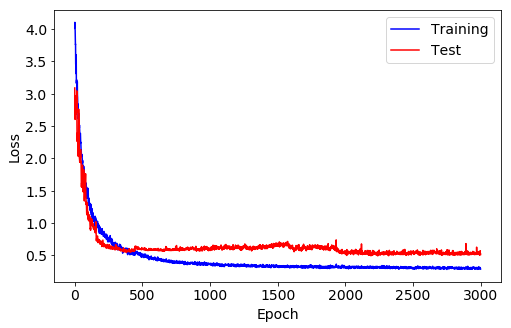

In [27]:
plot_history(history)

### Plot prediction vs experiment

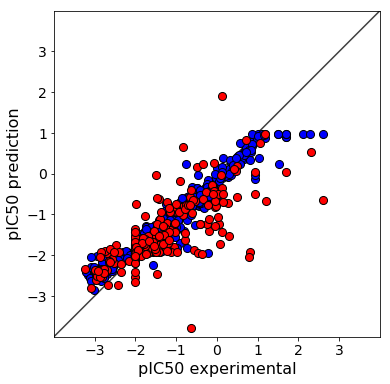

In [28]:
plot_eval(network)

### Save results

In [0]:
save_results(network, "MSE+RELU_NN")

### Statistics

In [30]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.75537159670677
MAE         : 0.4192232706211243
Kendall Tau : 0.652029420412494


### Cross-validation

In [0]:
#cross_validation(create_model, 60)

## <font color='green'>Linear Model</font>

A strightforward linear regression model.

### Single Layer Net

In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("linear"))
    
    model.compile(loss=custom_loss,                              # Custom loss function
                  optimizer=Adam(lr=learning_rate, decay=1e-6),  # Adam optimizer
                  metrics=['mse']) 	                             # measure performace
    return model

In [0]:
# Clearing the LM
shallow = None 
shallow = create_linear(input_dim)

### Rum, Rum

In [0]:
# Train shallow model
history = shallow.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=number_of_epochs,          # Number of epochs
                      verbose=0,                        # No output
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
#shallow.save("/content/shallow.h5")
#print("Saved model to disk")

### <font color='red'>Load model</font>

In [0]:
#shallow = None
#shallow = create_linear(x.shape[1])
#shallow.load_weights('/content/shallow.h5')

### Plot prediction vs experiment

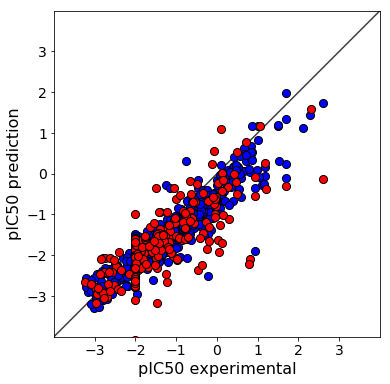

In [37]:
plot_eval(shallow)

### Save results

In [0]:
save_results(shallow, "MSE+RELU_LM")

### Statistics

In [39]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.799921632370705
MAE         : 0.49097212586943156
Kendall Tau : 0.6495439207158772


### Cross-validation

In [0]:
#cross_validation(create_linear, 60)

## <font color='green'>Control FCNN</font>

Repeat the previous methods but ignore censored data

### <font color='blue'>LOSS FUNCTION - without censored data</font>

In [0]:
def normal_loss(y_true, y_pred):
    '''Loss function for censored dataset
       training    
    '''
    z = y_pred - y_true
    return K.mean((1-s0_train)*K.square(z), axis=-1)

In [0]:
def mytest_loss(y_true, y_pred):
    '''Loss function for censored dataset
       testing
    '''
    z = y_pred - y_true
    return K.mean((1-s0_test)*K.square(z), axis=-1)

### Fully Connected Neural Network

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model2(x):
    # create model
    model = Sequential()
    
    # input layer
    model.add(Dense(units=100, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # hidden layer
    model.add(Dense(units=50))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # hidden layer
    model.add(Dense(units=25))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=normal_loss,                              # Normal loss function
                  optimizer=Adam(lr=learning_rate, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy', mytest_loss]) 	         # measure performace
    return model

In [0]:
# Clearing the NN
network2 = None 
network2 = create_model2(input_dim) 

### Corre Lolita

In [0]:
%%capture

# Train neural network
history = network2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=number_of_epochs,          # Number of epochs
                       verbose=0,                        # No output
                       batch_size=batch_size,            # Number of observations per batch
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
# network2.save("/content/network2.h5")
# print("Saved model to disk")

### <font color='red'>Load model</font>

In [0]:
#network2 = None
#network2 = create_model(x.shape[1])
#network2.load_weights('/content/network2.h5')

### Optimization performance

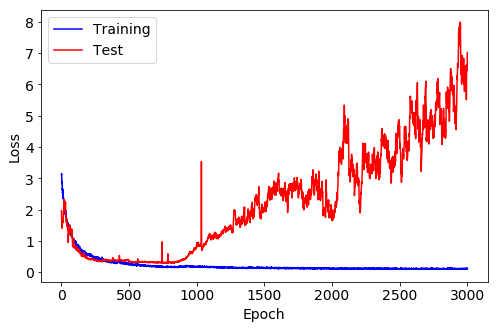

In [48]:
plot_history(history)

### Predictions versus Experiments

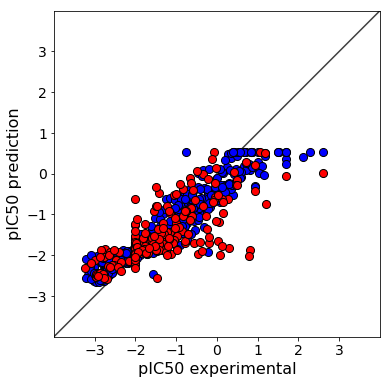

In [49]:
plot_eval(network2)

### Save results

In [0]:
save_results(network2, "MSE_NN")

### Statistics

In [51]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.3407562529231962
MAE         : 0.7898555406134005
Kendall Tau : 0.6406826989877334


### Cross-validation

In [0]:
#cross_validation(create_model2, 60)

## <font color='green'>Control LM</font>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Single Layer Net



In [0]:
# Function to create model
def create_linear2(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("linear"))
    
    model.compile(loss=normal_loss,                              # Custom loss function
                  optimizer=Adam(lr=learning_rate, decay=1e-6),  # Adam optimizer
                  metrics=['mse']) 	                             # measure performace
    return model

In [0]:
# Clearing the LM
shallow2 = None 
shallow2 = create_linear2(input_dim)

### Jogging

In [0]:
# Train shallow model
history = shallow2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=number_of_epochs,          # Number of epochs
                       verbose=0,                        # No output
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
#shallow2.save("/content/shallow2.h5")
#print("Saved model to disk")

### <font color='red'>Load model</font>

In [0]:
#shallow2 = None
#shallow2 = create_linear(x.shape[1])
#shallow2.load_weights('/content/shallow2.h5')

### Predictions versus Experiments

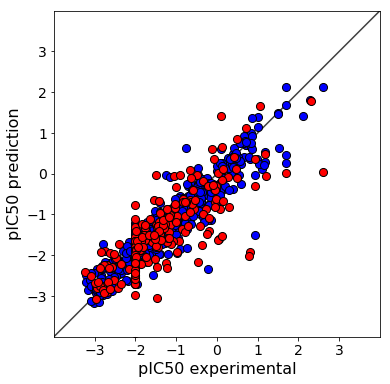

In [59]:
plot_eval(shallow2)

### Save results

In [0]:
save_results(shallow2, "MSE_LM")

### Statistics

In [61]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7999665094714185
MAE         : 0.4384124654269722
Kendall Tau : 0.656655211514531


### Cross-validation

In [0]:
#cross_validation(create_linear2, 60)

## <font color='green'>Validation</font>

External dataset from BindingDB for DNA Gyrase ([link](https://www.bindingdb.org/jsp/dbsearch/PrimarySearch_ki.jsp?polymerid=2626,50005944,2630,50004611,50006452&target=dna%20gyrase%20subunit%20b&tag=pol&startPg=0&submit=Search&energyterm=kJ%2Fmole&column=IC50))

### Data Processing

In [0]:
# load features dataset

filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/BindingDB_Gyrase_B_features.tsv"
validset = pd.read_csv(filepath)

# Rename columns

validset.rename(columns={'IC50':'pIC50'}, inplace=True)
validset.drop(['Ipc'], axis=1, inplace=True)

# Modify dataset

validset['pIC50'] = validset['pIC50'].apply(lambda x: np.log10(float(x)))

# Get x/y

vy = validset['pIC50'].copy()
vy = vy.astype('float64').to_numpy()

vx = validset[descriptors].copy()
vx = vx.astype('float64').to_numpy()

# Normalized features
# vx = Normalize(vx)

### Plot pIC50 predictions

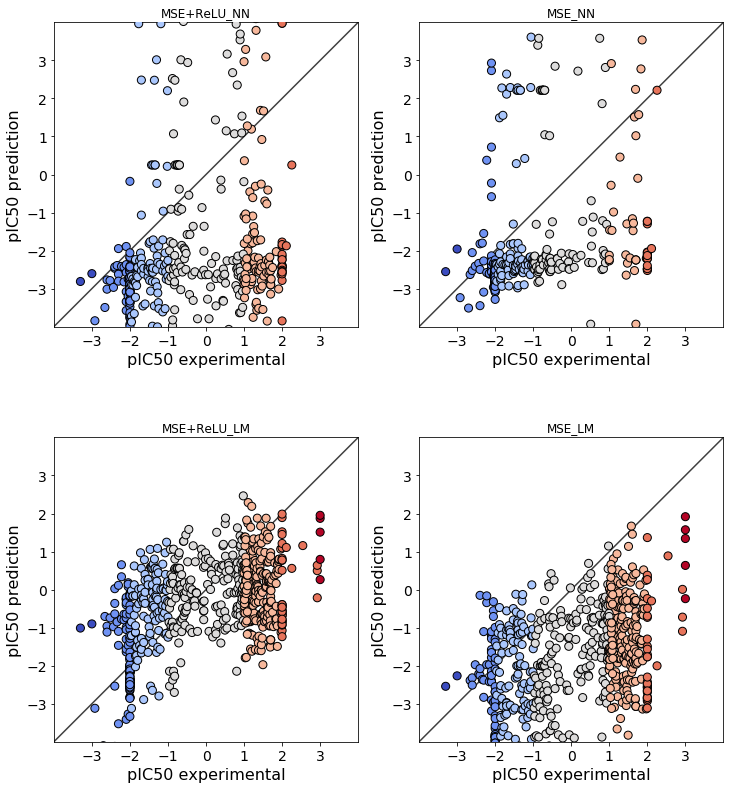

In [64]:
models = [network, network2, shallow, shallow2]
titles = ['MSE+ReLU_NN','MSE_NN','MSE+ReLU_LM','MSE_LM']

plt.rcParams["figure.figsize"] = (12,14)
plot_valid(models, titles)

### Save results

In [0]:
i = 0
for model in models:
    dt = {'y': vy,'y_pred': model.predict(vx)[:,0] }
    df = pd.DataFrame.from_dict(dt)
    df.to_csv("validation_" + titles[i] + ".csv"); i+=1

### Statistical Performance

In [66]:
labels = ['MSE+ReLu NN', 'MSE NN', 'MSE+ReLu LM', 'MSE LM']

i = 0
for name in [network, network2, shallow, shallow2]:
    
    slope, intercept, r_value, p_value, std_err = linregress(vy, name.predict(vx)[:,0])
    tau, p_value                                = kendalltau(vy, name.predict(vx)[:,0])
    rho, p_value                                = spearmanr( vy, name.predict(vx)[:,0])
    mae                                         = mean_absolute_error(vy, name.predict(vx)[:,0])
    mse                                         = mean_squared_error( vy, name.predict(vx)[:,0])
    
    print("##### METHOD: %s" % labels[i])
    print("Kendall Tau : %s" % tau)
    print("R2          : %s" % r_value)
    print("Spearman    : %s" % rho)
    print("MAE         : %s" % mae)
    print("RMSE        : %s" % np.sqrt(mse))
    print("")
    
    i+=1

##### METHOD: MSE+ReLu NN
Kendall Tau : 0.3203007834320884
R2          : 0.40137777407503816
Spearman    : 0.4600632367720094
MAE         : 9.466285221123222
RMSE        : 18.77693744558622

##### METHOD: MSE NN
Kendall Tau : 0.42118378653930594
R2          : 0.48435719910522296
Spearman    : 0.5986086824726974
MAE         : 30.38434344806177
RMSE        : 56.37640054611541

##### METHOD: MSE+ReLu LM
Kendall Tau : 0.2936559415613009
R2          : 0.48592940319853617
Spearman    : 0.4283518988241658
MAE         : 1.1517440784162183
RMSE        : 1.406592037374998

##### METHOD: MSE LM
Kendall Tau : 0.3278269155927173
R2          : 0.533087496849212
Spearman    : 0.4712793461426776
MAE         : 2.034341871579998
RMSE        : 2.380673060794365

